In [6]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec

import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import KFold

from sklearn.base import clone as sklearn_clone

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

import matplotlib.pyplot as plt

import spacy
from sentimentpl.models import SentimentPLModel
from autocorrect import Speller

import re
import unicodedata

from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7,progress_bar=True)

from parallelbar import progress_map

import pyphen
import re

from sklearn.preprocessing import StandardScaler

import seaborn as sns

nlp_core = spacy.load("pl_core_news_lg")
model_sent = SentimentPLModel(from_pretrained='latest')
spell = Speller('pl')
syllab = pyphen.Pyphen(lang='pl')
stopwords = nlp_core.Defaults.stop_words

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Lodad data

In [7]:
df_topics = pd.read_csv('../datasets/ready2use/topics.csv', index_col=0)
df_topics.shape

(6541, 1)

In [8]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

y_train = df.copy()['assestment'][df.index.isin(df_topics.index)]

X_train = df.copy()[['text_clean']][df.index.isin(df_topics.index)]

X_train['text_clean'] = X_train['text_clean'].apply( 
    lambda x:
    (x
     .replace('\n', ' ')
     .replace('ą', 'ą')
     .replace('ć', 'ć')
     .replace('ę', 'ę')
     .replace('ń', 'ń')
     .replace('ó', 'ó')
     .replace('ś', 'ś')
     .replace('ź', 'ź')
     .replace('ż', 'ż'))
)

In [9]:
y_train.shape

(6541,)

In [10]:
X_train.shape

(6541, 1)

## Get lexical features

In [11]:
def get_vowels_per_word(t):
    vowels = [len(re.findall('[aeiouóyąę]+', w)) for w in re.findall('(?![\d\s])[\w]+(?![\d\s])', t)]
    vowels = np.array(vowels)
    vowels = vowels[vowels>0]
    
    if vowels.shape[0] == 0:
        return [0]
    return vowels

In [12]:
# https://github.com/Hassaan-Elahi/Writing-Styles-Classification-Using-Stylometric-Analysis/blob/master/Detailed%20Report.pdf

In [13]:
X_train['avg_word_len'] = X_train['text_clean'].progress_apply(
    lambda x: np.mean(
        [ len(w.strip()) for w in re.findall('(?![\d])[\w]+', x)]
    )
)

X_train['n_words'] = X_train['text_clean'].progress_apply(
    lambda x: len( re.findall('(?![\d])[\w]+', x) )
)

X_train['n_char'] = X_train['text_clean'].progress_apply(
    lambda x: len(x)
)

X_train['n_special_char'] = X_train['text_clean'].progress_apply(
    lambda x: len(re.findall('(?![\d\s])[\W]', x))
)

X_train['avg_n_vowels_per_word'] = X_train['text_clean'].progress_apply(
    lambda x: np.mean(get_vowels_per_word(x.lower()))
)

100%|████████████████████████████████████| 6541/6541 [00:00<00:00, 35777.32it/s]


## Vocab richness

In [14]:
def get_vocab_rich_features(txt):
    uniq_words = {}
    words = ' '.join(re.findall('(?![\d])[\w]+', txt)).strip()
    doc = nlp_core(words)
    
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT', 'SYM', 'X', 'NUM']:
            lemma = token.lemma_
            if lemma in uniq_words:
                uniq_words[lemma] = uniq_words[lemma] + 1
            else:
                uniq_words[lemma] = 1
    
    n = len(words.split(' '))
    v = len(uniq_words)
    
    # Hapax Legomena and Hapax DisLegemena
    v1 = sum(x == 1 for x in uniq_words.values())
    v2 = sum(x == 2 for x in uniq_words.values())
    vi = {}
    for k in uniq_words.keys():
        n_w = uniq_words[k]
        if n_w in vi:
            vi[n_w] = vi[n_w] + 1
        else:
            vi[n_w] = 1
    # Honore’s measure R
    R = 100 * np.log(n+1) / (1 - v1/v + 1)
    # Sichel’s measure S 
    S = v2/v
    # Brunet’s measure W 
    # https://linguistics.stackexchange.com/questions/27365/formula-for-brun%C3%A9ts-index
    W = n**(v**(-0.17))
    # Yule’s characteristic K
    M = np.sum([n_w**2 * vi[n_w] for n_w in vi])
    K = 10**4 * (M-n)/(n**2)
    # Shannon Entropy
    E = np.sum([uniq_words[w]/n * np.log(uniq_words[w]/n) for w in uniq_words])
    # Simpson’s index D
    D = np.sum([(uniq_words[w]/n)**2 for w in uniq_words])
    # type token ratio (TTR)
    T = v/n
    
    return v1, v2, R, S, W, K, E, D, T

In [15]:
vocab_rich_f = X_train['text_clean'].progress_apply(
    lambda x: get_vocab_rich_features(x)
)

100%|██████████████████████████████████████| 6541/6541 [00:52<00:00, 125.71it/s]


In [16]:
X_train[
    ['hapax_legomena',
     'hapax_dislegemena',
     'honore_r',
     'sichel_s',
     'brunet_w',
     'yule_k',
     'shannon_entropy',
     'simpson_idx_d',
     'type_token_ratio'
    ]
] = vocab_rich_f.values.tolist()

## Readability

In [17]:
def get_vowels_per_word_complex(t, c=2):
    vowels = [len(re.findall('[aeiouóyąę]+', w)) for w in re.findall('(?![\d\s])[\w]+(?![\d\s])', t)]
    vowels = np.array(vowels)
    # complex word - more than 2 syllabes
    vowels = vowels[vowels>c]
    
    if vowels.shape[0] == 0:
        return [0]
    return vowels

In [18]:
X_train['FR_score'] = X_train['text_clean'].progress_apply(
    lambda x: 
    206.835 
    - 1.015 * len( re.findall('(?![\d])[\w]+', x) ) #total words
    - 84.6 *  np.sum(get_vowels_per_word(x.lower())) / len( re.findall('(?![\d])[\w]+', x) ) #total syllabes/ total words
)

X_train['FKG_level'] = X_train['text_clean'].progress_apply(
    lambda x: 
    0.39 * len( re.findall('(?![\d])[\w]+', x) ) #total words
    + 11.8 * np.sum(get_vowels_per_word(x.lower())) / len( re.findall('(?![\d])[\w]+', x) ) #total syllabes/ total words
    - 15.59
)

X_train['Gunning_Fog_index'] = X_train['text_clean'].progress_apply(
    lambda x: 
    0.4 * (
        len( re.findall('(?![\d])[\w]+', x) ) #total words
        + 100 * len(get_vowels_per_word_complex(x.lower())) / len( re.findall('(?![\d])[\w]+', x) ) 
    ) 
)

100%|████████████████████████████████████| 6541/6541 [00:00<00:00, 29113.70it/s]


## Add Sentiment

In [19]:
def get_sentiment(txt):
    doc = nlp_core(txt)
    
    sentiment_all = model_sent(txt).item()
    
    sentiments_list = []
    for i, sent in enumerate(doc.sents):
        s = model_sent(sent.text).item()
        sentiments_list.append(s)
    
    sentiment_avg = np.mean(sentiments_list)
    
    return sentiment_all, sentiment_avg

In [20]:
sentiment_f = X_train['text_clean'].progress_apply(
    lambda x: get_sentiment(x)
)

100%|███████████████████████████████████████| 6541/6541 [13:21<00:00,  8.16it/s]


In [21]:
X_train[
    ['sentiment_all',
     'sentiment_avg'
    ]
] = sentiment_f.values.tolist()

## Extra features

In [22]:
def get_n_stop_words(txt):
    doc = nlp_core(txt)
    
    n_sw = 0
    
    for token in doc:
        if token.lemma_ in stopwords:
            n_sw = n_sw + 1
    
    return n_sw

X_train['n_stop_words'] = X_train['text_clean'].progress_apply(
    lambda x: get_n_stop_words(x)
)


100%|██████████████████████████████████████| 6541/6541 [00:49<00:00, 130.89it/s]


In [23]:
def get_pos(txt):
    
    doc = nlp_core(txt)

    adj_n = 0
    adv_n = 0
    noun_n = 0
    ent_n = 0
   
    txt_pos = []
    txt_word = []
    for token in doc:
        if token.pos_ == 'ADJ': 
            adj_n += 1
        elif token.pos_ == 'ADV':
            adv_n += 1
        elif token.pos_ == 'NOUN':
            noun_n += 1

    for ent in doc.ents:
        ent_n += 1

    return (
        ent_n, 
        adj_n/len(txt.split(' ')), adj_n, 
        adv_n/len(txt.split(' ')), adv_n, 
        noun_n/len(txt.split(' ')), noun_n
    )

In [24]:
pos_f = X_train['text_clean'].progress_apply(
    lambda x: get_pos(x)
)

100%|██████████████████████████████████████| 6541/6541 [00:56<00:00, 116.80it/s]


In [25]:
X_train[
    ['n_ent',
     'p_adj',
     'n_adj',
     'p_adv',
     'n_adv',
     'p_noun',
     'n_noun'
    ]
] = pos_f.values.tolist()

## Add StyloMetrix

In [27]:
style_colnames = pd.read_html('https://github.com/ZILiAT-NASK/StyloMetrix/blob/v0.0.6/resources/metrics_list_pl.md')

In [31]:
style_colnames = style_colnames[0]['Code'].values.tolist()

In [32]:
with open('../datasets/ready2use/style_emb_pl.npy', 'rb') as f:
    emb_style = np.load(f) 

In [33]:
emb_style = pd.DataFrame(emb_style)

### Kfold

In [37]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [38]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_cv = df_topics.iloc[ train_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Experiments

In [39]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [40]:
def run_experiment(X, y,  cv, clf_org):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }
    coef_matrix = []
    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in tqdm(cv):
        clf = sklearn_clone(clf_org)
        
        scaler = StandardScaler()
        
        y_train_t, X_train_t = y[X.index.isin(train_cv)], X[X.index.isin(train_cv)]
        y_test_t, X_test_t = y[X.index.isin(test_cv)], X[X.index.isin(test_cv)]
        
        scaler.fit(X_train_t)
        X_train_t = scaler.transform(X_train_t)
        X_test_t = scaler.transform(X_test_t)
        
        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)
        
        coef_matrix.append(clf.coef_)
        
        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }

    return metrics, np.concatenate(coef_matrix, 0)

In [41]:
col_use = X_train.columns[1:].values.tolist()

col_use.remove('p_adj')
col_use.remove('p_adv')
col_use.remove('p_noun')

col_use

['avg_word_len',
 'n_words',
 'n_char',
 'n_special_char',
 'avg_n_vowels_per_word',
 'hapax_legomena',
 'hapax_dislegemena',
 'honore_r',
 'sichel_s',
 'brunet_w',
 'yule_k',
 'shannon_entropy',
 'simpson_idx_d',
 'type_token_ratio',
 'FR_score',
 'FKG_level',
 'Gunning_Fog_index',
 'sentiment_all',
 'sentiment_avg',
 'n_stop_words',
 'n_ent',
 'n_adj',
 'n_adv',
 'n_noun']

In [45]:
emb_style.shape

(6541, 89)

In [46]:
X_train.shape

(6541, 28)

In [49]:
X_final = pd.concat([X_train[col_use].reset_index(drop=True), emb_style.reset_index(drop=True)], axis=1)

In [50]:
out, m = run_experiment(X_final, y_train, cv_fold_i, clf_lr_1)
print(
    'styllsitic f lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|                                                    | 0/10 [00:00<?, ?it/s]/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
 10%|████▍                                       | 1/10 [00:00<00:01,  4.79it/s]/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/skle

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.53it/s]

styllsitic f lr C1 Accuracy 0.666+-0.003 F1 Score 0.641+-0.008  0.666+-0.003 | 0.641+-0.008


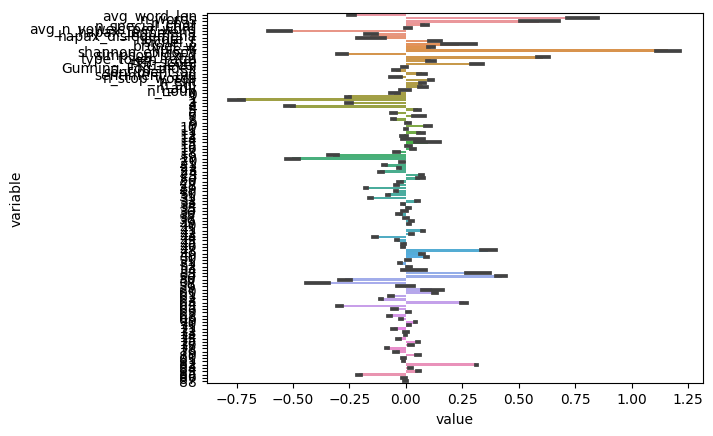

In [52]:
df_coefs = pd.DataFrame(m)
df_coefs.columns = X_final.columns
sns.barplot(data=df_coefs.melt(), y="variable", x="value")
plt.show()

In [55]:
out, m = run_experiment(X_final, y_train, cv_Kfold_i, clf_lr_1)
print(
    'styllsitic f lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

  0%|                                                    | 0/10 [00:00<?, ?it/s]/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
 10%|████▍                                       | 1/10 [00:00<00:02,  3.53it/s]/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/skle

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.09it/s]

styllsitic f lr C1 Accuracy 0.667+-0.002 F1 Score 0.642+-0.003  0.667+-0.002 | 0.642+-0.003


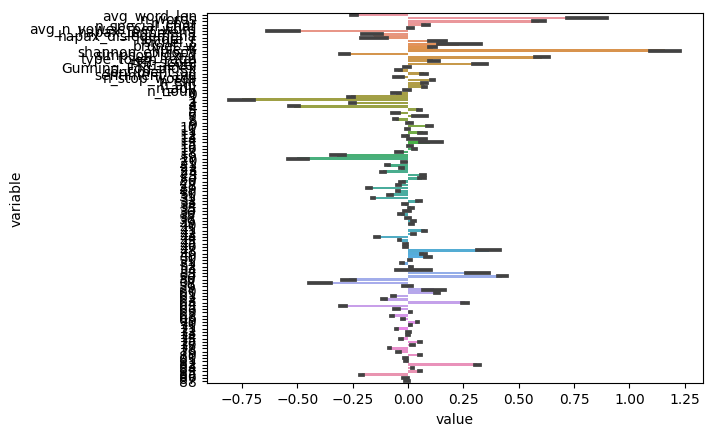

In [56]:
df_coefs = pd.DataFrame(m)
df_coefs.columns = X_final.columns
sns.barplot(data=df_coefs.melt(), y="variable", x="value")
plt.show()